In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
np.set_printoptions(suppress=True, precision=2)
import matplotlib as mpl
import matplotlib.pyplot as plt

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

# Bag of Words

In [73]:
from sklearn.feature_extraction.text import CountVectorizer

documents = [
    "The car is driven on the road", 
    "The truck is driven on the highway",
]
count_vectorizer = CountVectorizer()
bag_of_words = count_vectorizer.fit_transform(documents)
feature_names = count_vectorizer.get_feature_names()
pd.DataFrame(bag_of_words.toarray(), columns=feature_names)

,car,driven,highway,is,on,road,the,truck
0,1,1,0,1,1,1,2,0
1,0,1,1,1,1,0,2,1


In [83]:
import nltk
from nltk.util import ngrams

text = "A B B A B"
tokens = nltk.word_tokenize(text)

n = 2
ngrams = list(ngrams(tokens, n))
print(ngrams)

fdist = nltk.FreqDist(ngrams)
print(fdist.items())

[('A', 'B'), ('B', 'B'), ('B', 'A'), ('A', 'B')]
dict_items([(('A', 'B'), 2), (('B', 'B'), 1), (('B', 'A'), 1)])


# TF-IDF

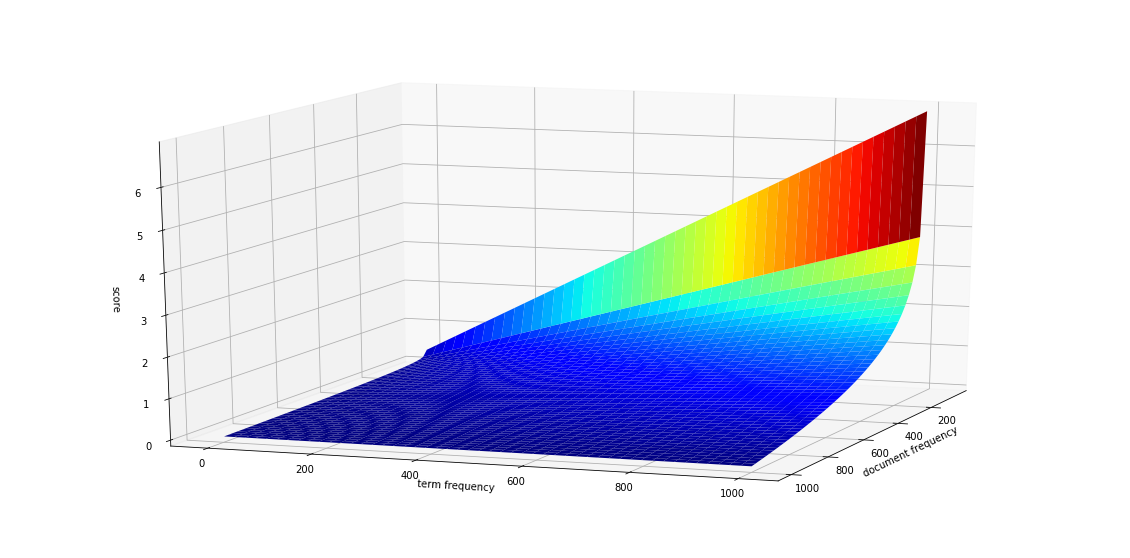

In [20]:
from mpl_toolkits.mplot3d import Axes3D

cn = 1000  # Number of documents in the corpus.
dn = 1000  # Number of words in the document. 

def tfidf(tf, df):
    return tf/dn * np.log(cn/df)

if __name__ == "__main__":   
    lim = 1000.0
    n = 50
    tf_ls = np.linspace(50, lim, n)
    df_ls = np.linspace(1, lim, n)

    score = np.zeros((n, n))
    for ai in range(n):
        for bi in range(n):
            score[ai, bi] = tfidf(tf_ls[ai], df_ls[bi])
    
    tf_mg, df_mg = np.meshgrid(tf_ls, df_ls)

    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.view_init(15, 20)
    ax.plot_surface(tf_mg, df_mg, score, cmap=mpl.cm.jet)
    ax.set_xlabel('document frequency')
    ax.set_ylabel('term frequency')
    ax.set_zlabel('score')
    
    plt.savefig("tfidf.png", dpi=300, bbox_inches='tight')

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [
    "The car is driven on the road", 
    "The truck is driven on the highway",
]
tfidf_vectorizer = TfidfVectorizer(norm=None, use_idf=True)
bag_of_words = tfidf_vectorizer.fit_transform(corpus)
feature_names = tfidf_vectorizer.get_feature_names()
array = bag_of_words.toarray()
pd.DataFrame(array, columns=feature_names)

,car,driven,highway,is,on,road,the,truck
0,1.405465,1.0,0.000000,1.0,1.0,1.405465,2.0,0.000000
1,0.000000,1.0,1.405465,1.0,1.0,0.000000,2.0,1.405465


Scikit-learn defines TF-IDF as:

$tfidf(t, d, c) = tf(t, d) \cdot \left(\ln{\left(\frac{n}{df(t, c)}\right)} + 1\right)$

where

- $t$ - token,
- $d$ - document,
- $c$ - corpus,
- $n$ - number of documents in the corpus,
- $tf$ - number of token occurences in the document,
- $df$ - number of documents containing the token.

Additionaly it applies smoothing by default what redefines the $tfidf$ formula to:

$tfidf(t, d, c) = tf(t, d) \cdot \left(\ln{\left(\frac{n + 1}{df(t, c) + 1}\right)} + 1\right)$

Word "another" has score 1.41 because:

$tfidf(t, d, c) = 1 \cdot \left(\ln{\left(\frac{2 + 1}{1 + 1}\right)} + 1 \right) = \ln{\left(\frac{3}{2} \right) +1} = 1.41$

# BM25

In [27]:
from bokeh.models.widgets import Slider
from bokeh.layouts import layout, column
from bokeh.models import CustomJS, ColumnDataSource
from functools import partial

DEFAULT_K = 1.2
DEFAULT_B = 0.8
DEFAULT_L = 1.0

def bm25(tf, k=DEFAULT_K, b=DEFAULT_B, l=DEFAULT_L):
    return (tf * (k + 1))/(tf + k*(1 - b + b*l))

xs = range(0, 100)
ys = [bm25(x) for x in xs]
source = ColumnDataSource(data={"x":xs, "y":ys})
    
fig = figure(plot_width=400, plot_height=400, x_range=(0, 100), y_range=(0, 10))
fig.line('x', 'y', source=source, line_width=3, line_alpha=0.6)
fig.xaxis.axis_label = "Term frequency"
fig.yaxis.axis_label = "Score"

k = Slider(start=0.0, end=10, value=DEFAULT_K, step=.1, title="k")
b = Slider(start=0.0, end=10, value=DEFAULT_B, step=.1, title="b")
l = Slider(start=0.1, end=10, value=DEFAULT_L, step=.1, title="l")

update = CustomJS(args=dict(source=source, k=k, b=b, l=l), code="""
    var data = source.data;
    var k = k.value;
    var b = b.value;
    var l = l.value;
    x = data['x'];
    y = data['y'];
    for (i = 0; i < x.length; i++) {
        y[i] = (x[i] * (k + 1)) / (x[i] + k*(1 - b + b*l));
    }
    source.change.emit();
""")
k.js_on_change("value", update)
b.js_on_change("value", update)
l.js_on_change("value", update)

layout = column(k, b, l, fig)
show(layout)

It looks that from popular NLP python packages only gensim implements BM25. Gensim implementation doesn't expose "k" and "b" as parameters and it scores only whole documents. The following code calculates score of a sentence against all sentences in the corpus. The bigger score the more similar sentences.

In [81]:
from gensim.summarization.bm25 import get_bm25_weights, BM25

corpus = [
     ["black", "cat", "white", "cat"],
     ["cat", "outer", "space"],
     ["wag", "dog"]
]

bm25 = BM25(corpus)
scores = np.array(bm25.get_scores(["black", "dog"]))
print(scores)

[0.44 0.   0.6 ]
